### ELLA results plots

In [ ]:
import time
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
from collections import Counter
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

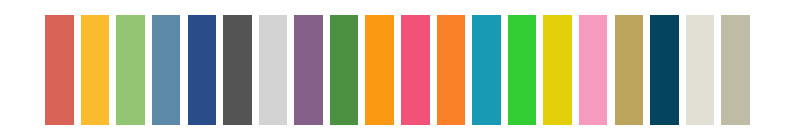

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load ella results

In [3]:
fn = '../ella/output_ella/ella_seqfish_np20.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

#### number of cells and genes

In [4]:
for t in types_list:
    print(f'{t}\nnumber of cells={len(cells_dict[t])}\nnumber of genes={len(genes_dict[t])}\nnumber of sig genes={np.sum(p_fdr_dict[t]<=0.05)}')

fibroblast
number of cells=171
number of genes=2747
number of sig genes=2744


#### fibroblast cell type

there's only one cell type in this cell line dataset

In [5]:
# merge labels
labels_cluster, labels_num = np.unique(label_dict['fibroblast'], return_counts=True)
print(labels_cluster)
print(labels_num)

[-1  0  1  2  3  4]
[   3   32  501  572 1531  108]


32 (1%)
501 (18%)
572 (21%)
1531 (56%)
108 (4%)


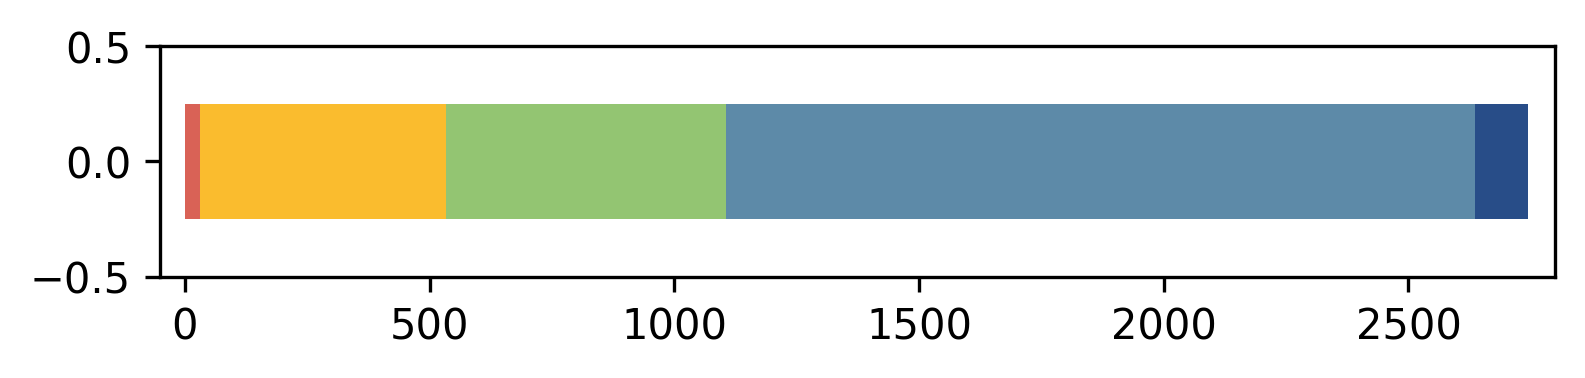

In [6]:
# barplot number of genes
bar_width = 0.5
bar_positions = [0, 1]
colors = [red, lightorange, lightgreen, lightblue, darkblue]

nr = 1
nc = 1
ss_nr = 1
ss_nc = 6
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

# sig genes
labels_num_sig = labels_num[1:]
left = 0
for i in range(5):
    ax.barh(bar_positions[0], labels_num_sig[i], bar_width, left=left, color=colors[i])
    left += labels_num_sig[i]
    print(f'{labels_num_sig[i]} ({labels_num_sig[i]/np.sum(labels_num_sig)*100:.0f}%)')

ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-50, 2800)

# plt.savefig(f'figs/fig_labels.pdf', dpi=300, bbox_inches='tight')

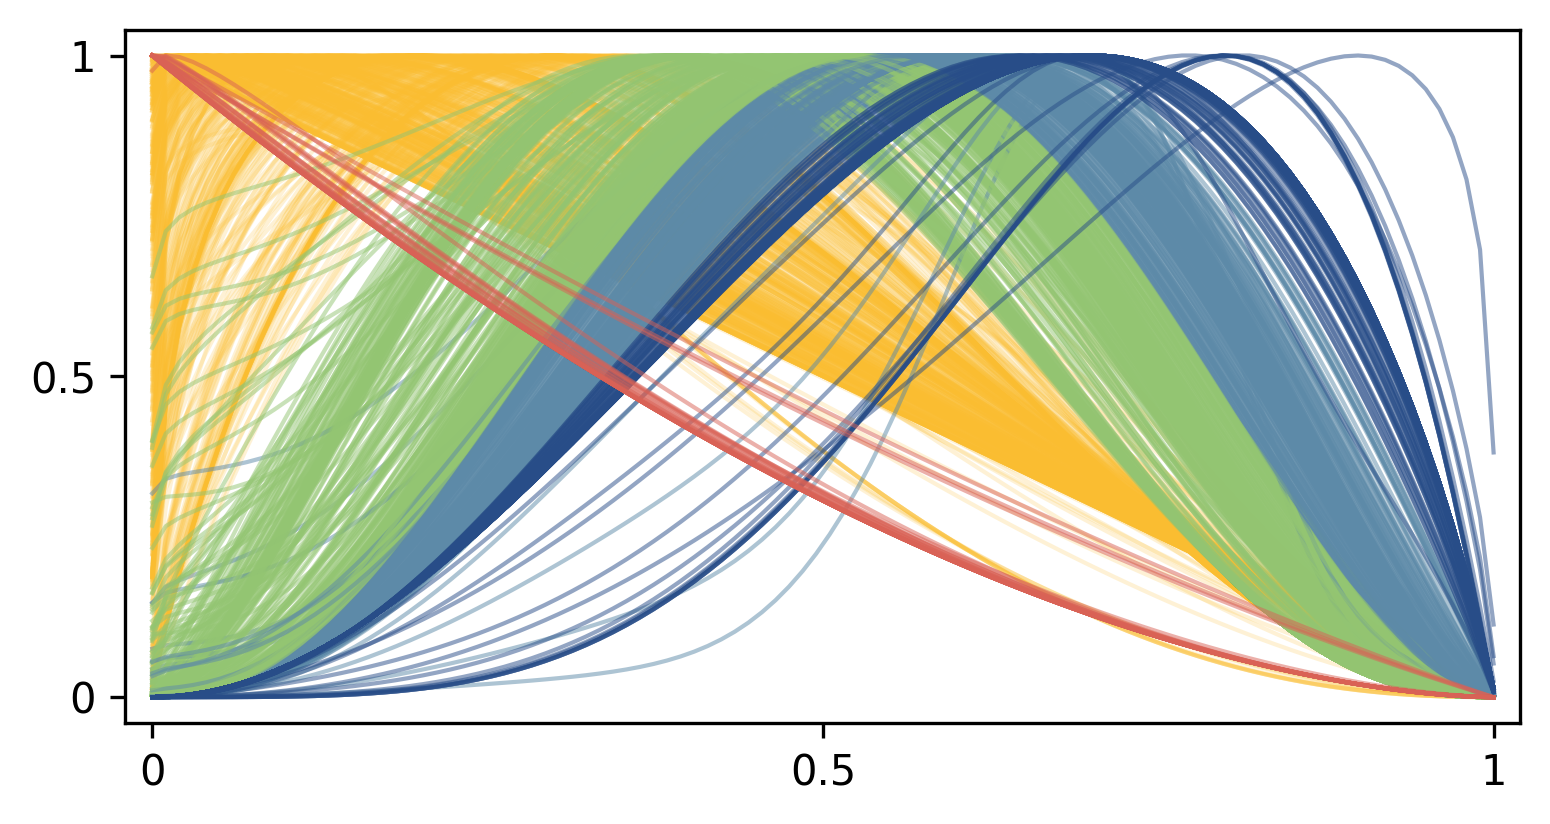

In [7]:
# lam est
x = np.linspace(0, 1, 100)
colors = [red, lightorange, lightgreen, lightblue, darkblue]

nr = 1
nc = 1
ss_nc = 6
ss_nr = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

for t in types_list:
    label_t = label_dict[t]
    lam_t = lam_dict[t]
    gene_t = genes_dict[t]
    for j in range(len(gene_t)):
        l = label_t[j]
        if l>-1:
            color = colors[l]
            if color==red:
                zorder=5
                alpha=0.5
            elif color==darkblue: 
                zorder=4
                alpha=0.5
            elif color==lightgreen: 
                zorder=3
                alpha=0.5
            elif color==lightblue:
                zorder=3
                alpha=0.5
            else: 
                zorder=1
                alpha=0.2
            lam_j = lam_t[j]
            lam_std_j = (lam_j-np.min(lam_j))/(np.max(lam_j)-np.min(lam_j)) # min-max std
            ax.plot(x, lam_std_j, alpha=alpha, lw=1.0, color=color, zorder=zorder)

ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.04, 1.04)
__ = ax.set_xticks([0,0.5,1], [0,0.5,1])
__ = ax.set_yticks([0,0.5,1], [0,0.5,1])

# plt.savefig(f'figs/fig_lam.pdf', dpi=300, bbox_inches='tight')

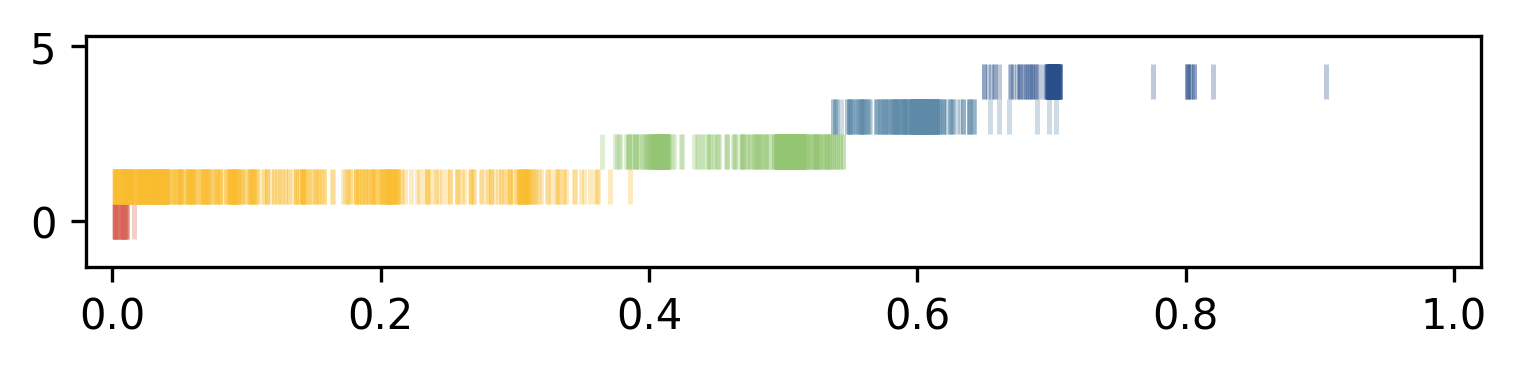

In [9]:
# pattern scores event plot
scores_all = np.concatenate(list(score_dict.values()))
scores_all_sig = scores_all[labels_all>-1]
labels_all_sig = labels_all[labels_all>-1]

colors = [red, lightorange, lightgreen, lightblue, darkblue]

nr = 1
nc = 1
ss_nc = 6
ss_nr = 1
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

alpha=0.3
ll=1
lw=1.2

for k in range(5):
    scores_k = scores_all_sig[labels_all_sig==k]
    ax.eventplot([scores_k + np.random.uniform(0, 0.01, len(scores_k))], 
                 orientation='horizontal', 
                 colors=[colors[k]],
                 alpha=alpha,
                 linelengths=ll, lw=lw, lineoffsets=k)

ax.set_xlim(-0.02, 1.02)

# plt.savefig(f'figs/fig_score_event.pdf', dpi=300, bbox_inches='tight')

#### details in fibroblast cell type

In [11]:
# lnc genes
def parse_gencode_annotation(annotation_file):
    lnc_genes = set()
    with open(annotation_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            fields = line.strip().split('\t') 
            if fields[2] == 'gene' and ' gene_type "lncRNA"' in fields[8].split(';'):
                gene_name = fields[8].split(';')[2].split('"')[1]  # Extract gene name
                lnc_genes.add(gene_name)
    return lnc_genes

def check_if_lnc(genes_list, lnc_genes):
    lnc_genes_in_list = [gene for gene in genes_list if gene in lnc_genes]
    return lnc_genes_in_list

annotation_file = 'input/gencode.vM34.annotation.gtf'
genes_list = np.array(genes_dict['fibroblast'])[p_fdr_dict['fibroblast']<=0.05]
lnc_genes = parse_gencode_annotation(annotation_file)
lnc_genes_in_list = check_if_lnc(genes_list, lnc_genes)
print(len(lnc_genes_in_list))

0


In [12]:
# TF genes
fn = 'input/Browse Transcription Factors mm9 - resource_browser.csv'
tab = pd.read_csv(fn)
tf_list = tab.Symbol.unique().tolist()
print(f'total #TF {len(tf_list)}')

list1_lower = [item.lower() for item in tf_list]
list2_lower = [item.lower() for item in genes_dict['fibroblast']]
seqfish_TFs = set(list1_lower).intersection(set(list2_lower))
print(f'included #TF {len(seqfish_TFs)}')

list1_lower = [item.lower() for item in tf_list]
list2_lower = [item.lower() for item in np.array(genes_dict['fibroblast'])[p_fdr_dict['fibroblast']<=0.05]]
seqfish_TFs_sig = set(list1_lower).intersection(set(list2_lower))
print(f'sig #TF {len(seqfish_TFs_sig)}')

total #TF 1385
included #TF 244
sig #TF 244


#### check seqfish+ identified genes

In [13]:
# seqfish+ genes in extended data fig 3
protrusion20List = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Net1', 'Trak2', 
                    'Kif1c', 'Kctd10', 'Dynll2', 'Arhgap11a', 'Gxylt1',
                    'H6pd', 'Gdf11', 'Dync1li2', 'Palld', 'Ppfia1',
                    'Naa50', 'Ptgfr', 'Zeb1', 'Arhgap32', 'Scd1']
nuclear20List = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn',
                 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1', 
                 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6',
                 'Col5a2', 'Itgb1', 'Calu', 'Pdia3', 'Cyr61']
cytoplasm20List = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1',
                   'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln',
                   'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1',
                   'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']
nuclearSub1List = ['Cyr61', 'Thbs1', 'Ctgf', 'Serpine1', 'Ptx3', 'Tnc']
nuclearSub2List = ['Flna', 'Flnb', 'Plec', 'Flnc', 'Iqgap1']
nuclearSub3List = ['Bicd2', 'Nin', 'Pcnt', 'Numa1', 'Spdl1', 
                   'Ctif', 'Cep350', 'Trip11', 'Gorasp2']

In [14]:
# find labels
labels_protrusion20List = []
for g in protrusion20List:
    if g in genes_dict['fibroblast']:
        ig = np.where(genes_dict['fibroblast']==g)[0][0]
        labels_protrusion20List.append(label_dict['fibroblast'][ig])
    else:
        labels_protrusion20List.append(-2)
        

labels_nuclear20List = []
for g in nuclear20List:
    if g in genes_dict['fibroblast']:
        ig = np.where(genes_dict['fibroblast']==g)[0][0]
        labels_nuclear20List.append(label_dict['fibroblast'][ig])
    else:
        labels_nuclear20List.append(-2)
        
labels_cytoplasm20List = []
for g in cytoplasm20List:
    if g in genes_dict['fibroblast']:
        ig = np.where(genes_dict['fibroblast']==g)[0][0]
        labels_cytoplasm20List.append(label_dict['fibroblast'][ig])
    else:
        labels_cytoplasm20List.append(-2)

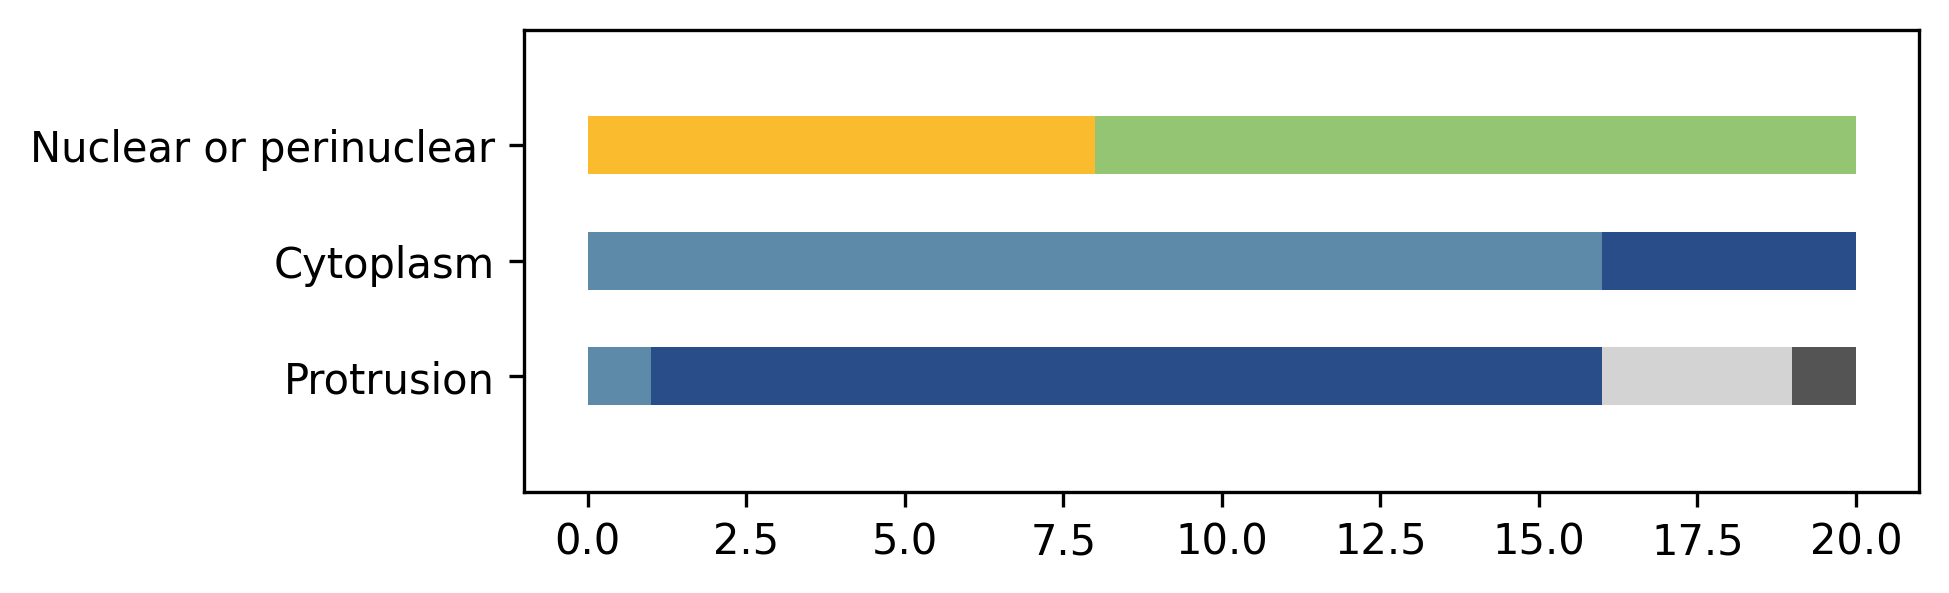

In [15]:
# barplot labels of seqfish+ genes
bar_width = 0.5
colors = [red, lightorange, lightgreen, lightblue, darkblue, lightgray, darkgray]

nr = 1
nc = 1
ss_nr = 2
ss_nc = 6
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

# nuclear20
bar_positions = 2
left = 0
labels_ = np.array(labels_nuclear20List)
for j in range(7):
    k = [0,1,2,3,4,-1,-2][j]
    ax.barh(bar_positions, np.sum(labels_==k), bar_width, left=left, color=colors[j])
    left += np.sum(labels_==k)

# cytoplasm20
bar_positions = 1
left = 0
labels_ = np.array(labels_cytoplasm20List)
for j in range(7):
    k = [0,1,2,3,4,-1,-2][j]
    ax.barh(bar_positions, np.sum(labels_==k), bar_width, left=left, color=colors[j])
    left += np.sum(labels_==k)
    
# protrusion20
bar_positions = 0
left = 0
labels_ = np.array(labels_protrusion20List)
for j in range(7):
    k = [0,1,2,3,4,-1,-2][j]
    ax.barh(bar_positions, np.sum(labels_==k), bar_width, left=left, color=colors[j])
    left += np.sum(labels_==k)

ax.set_ylim(-1, 3)
ax.set_xlim(-1, 21)
ax.set_yticks([0,1,2], ['Protrusion', 'Cytoplasm', 'Nuclear or perinuclear'])

# plt.savefig(f'figs/fig_labels_three_lists.pdf', dpi=300, bbox_inches='tight')